In [2]:
from skyfield.api import Topos, load, EarthSatellite
import matplotlib.pyplot as plt
from skyfield.api import Time
from datetime import datetime, timedelta
import numpy as np
import sys
import pytz
import math
from math import pow
from math import radians
import astropy.time
import astropy.coordinates
import lumos.calculator
import lumos.conversions
from skyfield.api import Topos, load, EarthSatellite
import matplotlib.pyplot as plt
from skyfield.api import Time
from datetime import datetime, timedelta
import numpy as np
import pytz
import math
from math import radians
import pandas as pd

sys.path.append('/Users/physarah/Development/satellite-optical-brightness/analysis')


import satellite_models.diffuse_sphere as diffuse_sphere
import satellite_models.starlink_v1p5 as starlink_v1p5
%matplotlib inline

satellite_data = pd.read_csv('/Users/physarah/Development/satellite-optical-brightness/daytime/reduced_data/starlink-30094-56305C-P1.csv')

In [3]:
tle_line1 = "STARLINK-30094"     # up to date as of 24th Jan 2024     
tle_line2 = "1 56305U 23056V   24029.50673422  .00021669  00000+0  16486-2 0  9991"
tle_line3 = "2 56305  43.0028  74.6944 0000983 256.5674 103.5058 15.01736336 43584"

ts = load.timescale()
satellite = EarthSatellite(tle_line2, tle_line3, name=tle_line1)        

observer_location = Topos('33.7703 S', '151.1112 E', elevation_m=70) # Macquarie Observatory

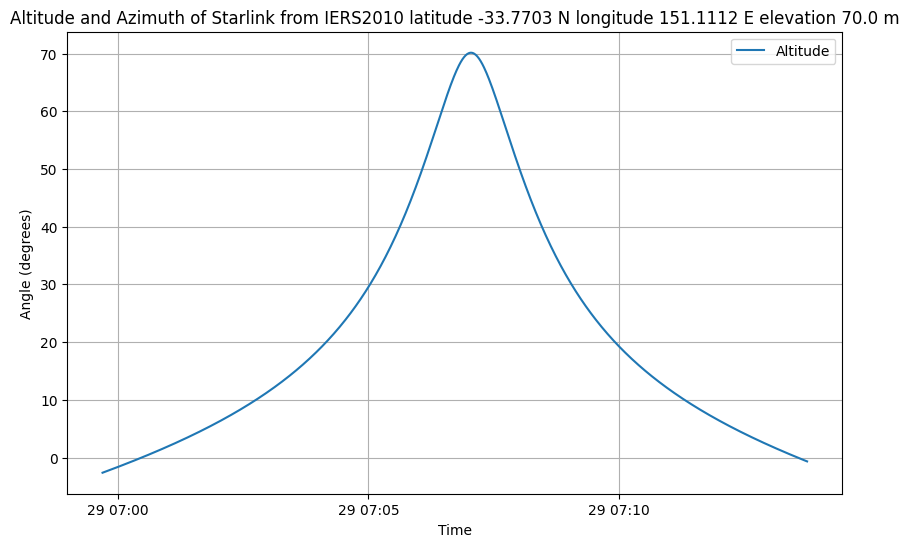

In [4]:
ts = load.timescale()
satellite = EarthSatellite(tle_line2, tle_line3, name="Starlink")        
observer_location = Topos('33.7703 S', '151.1112 E', elevation_m=70)

start_time = list(pd.to_datetime(satellite_data['datetimes_sat']))[0] - timedelta(minutes = 7, seconds = 30)
end_time = list(pd.to_datetime(satellite_data['datetimes_sat']))[-1] + timedelta(minutes = 4, seconds = 30)

time_step = timedelta(seconds=1)
times = []
time = start_time
while time < end_time:
    times.append(time)
    time += time_step
    
times2 = []
for timestamp_pd in times:
    TIME_PD = timestamp_pd.replace(tzinfo=pytz.utc)
    time_sf = ts.utc(TIME_PD)
    times2.append(time_sf)

altitudes_line = []
azimuths_line = []
sep_angle_line = []
distance_list_line = []

for time in times2:
    topocentric = (satellite - observer_location).at(time)
    satellite_position = satellite.at(time)
    earth_radius = 6371.0  # Radius of the Earth in kilometers
    satellite_position = satellite.at(time)

    observer_latitude = radians(-33.7703)  # Convert to radians
    observer_longitude = radians(151.1112)  # Convert to radians
    
    earth_radius_km = 6371.0  # Approximate Earth radius in kilometers

    delta_longitude = satellite_position.subpoint().longitude.radians - observer_longitude
    delta_latitude = satellite_position.subpoint().latitude.radians - observer_latitude

    a = (pow(math.sin(delta_latitude / 2), 2) +
         math.cos(observer_latitude) * math.cos(satellite_position.subpoint().latitude.radians) *
         pow(math.sin(delta_longitude / 2), 2))
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    distance_km = earth_radius_km * c
    distance_list_line.append(distance_km)

    alt, az, _ = topocentric.altaz()
    altitudes_line.append(alt.degrees)
    azimuths_line.append(az.degrees)
    
times_datetime = [t.utc_datetime() for t in times2]

plt.figure(figsize=(10, 6))
plt.plot(times_datetime, altitudes_line, label="Altitude")
#plt.plot(times_datetime, azimuths, label="Azimuth")
plt.xlabel("Time")
plt.ylabel("Angle (degrees)")
plt.legend()
plt.title(f"Altitude and Azimuth of {satellite.name} from {observer_location}")
plt.grid()
plt.show()

In [5]:
def generate_datetime_range(start_time, end_time, interval, time_delta):
    """
    Generate a list of datetimes between start_time and end_time at a given interval.
    """
    current_time = start_time
    datetime_list = []

    while current_time <= end_time:
        datetime_list.append(current_time - timedelta(hours = time_delta))
        current_time += interval

    return datetime_list

#sat_height = np.array([(570* 1000 + 540* 1000)/2]*len(utc_datetime))

In [6]:
satellite_heights = np.array([(570* 1000 + 540* 1000)/2]*len(times2))
observation_times = [dt.to_astropy() + timedelta(hours = 0) for dt in times2]
satellite_altitudes = altitudes_line
satellite_azimuths = azimuths_line
measured_magnitudes = np.random.rand(len(satellite_azimuths))

In [7]:
mount_lemmon = astropy.coordinates.EarthLocation(lat = -33.7703, lon = 151.1112)

In [8]:
import lumos.constants as cst
cst.SUN_INTENSITY

1233

In [9]:
intensities_diffuse_sphere = np.zeros_like(measured_magnitudes)
intensities_lab_brdfs = np.zeros_like(measured_magnitudes)
intensities_inferred_brdfs = np.zeros_like(measured_magnitudes)

sun_alt_list, sun_az_list = ([],[])
for i, (sat_alt, sat_az, sat_h, time) in \
    enumerate(zip(satellite_altitudes, satellite_azimuths, satellite_heights, observation_times)):
    
    observation_time = astropy.time.Time(time, format = 'isot')
    sun_alt, sun_az = lumos.calculator.get_sun_alt_az(observation_time, mount_lemmon)
    sun_alt_list.append(sun_alt)
    sun_az_list.append(sun_az)
        
    # intensities_diffuse_sphere[i] = \
    #     diffuse_sphere.get_intensity(0.65, sat_h, sat_alt, sat_az, sun_alt, sun_az)
    
    intensities_lab_brdfs[i] = \
        lumos.calculator.get_intensity_observer_frame(
            starlink_v1p5.SURFACES_LAB_BRDFS,
            sat_h, sat_alt, sat_az, sun_alt, sun_az,
            include_earthshine = True,
            earth_panel_density=300,
            earth_brdf=lumos.brdf.library.PHONG(0.9, 0.28, 0)) # use the vegitation example that Forrest uses 
            #earth_brdf=lumos.brdf.library.LAMBERTIAN(0.8))
    intensities_inferred_brdfs[i] = \
        lumos.calculator.get_intensity_observer_frame(
            starlink_v1p5.SURFACES_INFER_BRDFS,
            sat_h, sat_alt, sat_az, sun_alt, sun_az,
            include_earthshine = True,
            earth_brdf=lumos.brdf.library.PHONG(0.53, 0.28, 7.31)) # use the vegitation example that Forrest uses 

#magnitudes_diffuse_sphere = lumos.conversions.intensity_to_ab_mag(intensities_diffuse_sphere)
magnitudes_lab_brdfs = lumos.conversions.intensity_to_ab_mag(intensities_lab_brdfs)
magnitudes_inferred_brdfs = lumos.conversions.intensity_to_ab_mag(intensities_inferred_brdfs)

(8.0, 0.0)

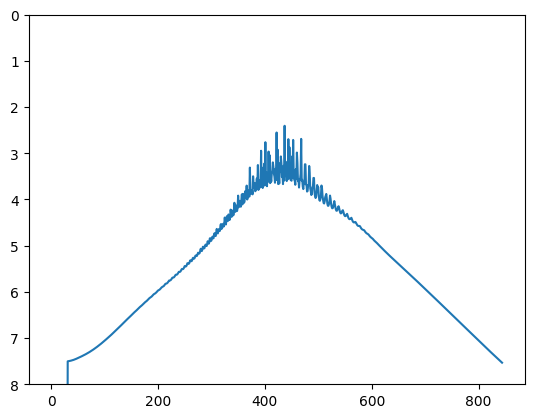

In [10]:
plt.plot(magnitudes_lab_brdfs)
plt.ylim(8,0)

In [11]:
datetime_iss = []
for i in pd.to_datetime(satellite_data['utc']):
    datetime_iss.append(i.to_pydatetime())

datetime_iss2 = []
for i in datetime_iss:
    datetime_iss2.append(i)

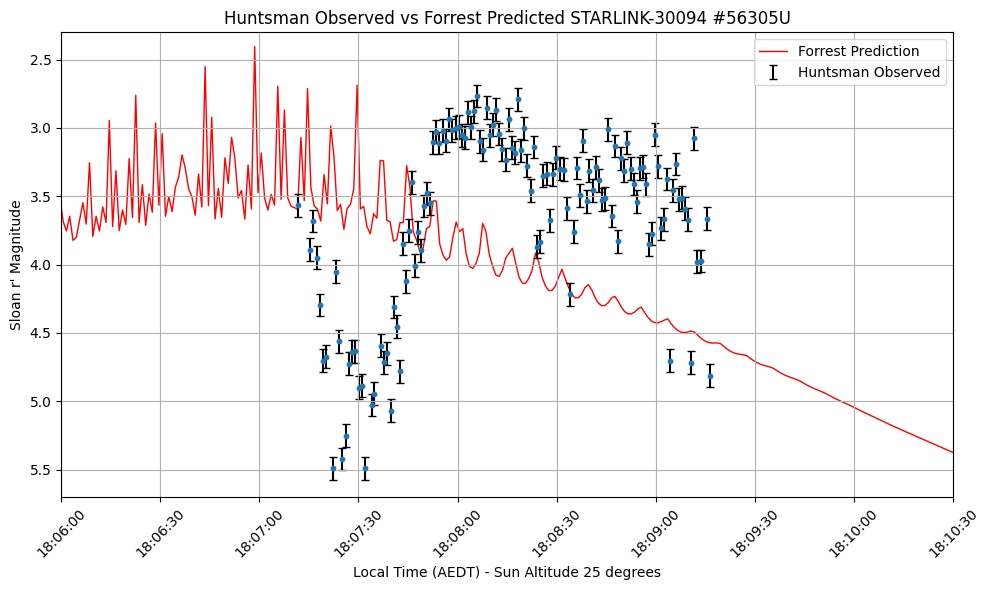

In [30]:
plt.figure(figsize=(10, 6))
plt.errorbar([dt + timedelta(hours = 11) for dt in datetime_iss2],
             satellite_data['calibed_mags'], 
             yerr=[np.sqrt(0.08369540784858925**2)]*len(satellite_data['calibed_mags']), 
             ls = '', c = 'black', capsize = 3, zorder = 1, label = 'Huntsman Observed')
plt.scatter([dt + timedelta(hours = 11) for dt in datetime_iss2], satellite_data['calibed_mags'],  zorder = 2, s = 10)
plt.plot([dt + timedelta(hours = 11) for dt in times_datetime],
         magnitudes_lab_brdfs, label = 'Forrest Prediction', color = 'red', ls = '-', lw = 1, zorder = 0)
plt.xlabel("Local Time (AEDT) - Sun Altitude 25 degrees")
plt.legend()
plt.ylabel("Sloan r' Magnitude")
plt.ylim(5.7,2.3)
plt.title("Huntsman Observed vs Forrest Predicted STARLINK-30094 #56305U")
plt.grid(True)
plt.xlim(datetime(2024, 1, 29, 18, 6, 0),datetime(2024, 1, 29, 18, 10, 30))
plt.xticks(rotation = 45)
plt.tight_layout()
plt.savefig("/Users/physarah/Desktop/starlink-30094-56305U.png")